In [1]:
import xarray as xr

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)


dataset

<xarray.Dataset>
Dimensions:  (phalf: 41, time: 1440, lon: 128, lonb: 129, lat: 64, latb: 65,
              pfull: 40)
Coordinates:
  * phalf    (phalf) float32 0.0 0.4844 0.6312 0.8205 ... 863.5 941.4 1e+03
  * time     (time) float64 8.64e+03 8.64e+03 8.641e+03 ... 9e+03 9e+03 9e+03
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lonb     (lonb) float32 -1.406 1.406 4.219 7.031 ... 350.2 353.0 355.8 358.6
  * lat      (lat) float32 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * latb     (latb) float32 -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * pfull    (pfull) float32 0.1782 0.5562 0.7238 0.9395 ... 821.4 902.2 970.5
Data variables:
    bk       (phalf) float32 ...
    pk       (phalf) float32 ...
    ps       (time, lat, lon) float32 ...
    ucomp    (time, pfull, lat, lon) float32 ...
    vcomp    (time, pfull, lat, lon) float32 ...
    temp     (time, pfull, lat, lon) float32 ...
    sphum    (time, pfull, lat, lon) float32 ...
    omega    (time, pfull, lat, lon) float32 ...
    precip   (time, lat, lon) float32 ...
    evap     (time, lat, lon) float32 ...
    t_surf   (time, lat, lon) float32 ...
Attributes:
    filename:  atmos_4xdaily.nc
    title:     MiMA

In [2]:
# Access the 'vcomp' variable
vcomp_data = dataset['vcomp']

# Print all values of the 'vcomp' variable
vcomp_data

<xarray.DataArray 'vcomp' (time: 1440, pfull: 40, lat: 64, lon: 128)>
[471859200 values with dtype=float32]
Coordinates:
  * time     (time) float64 8.64e+03 8.64e+03 8.641e+03 ... 9e+03 9e+03 9e+03
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float32 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * pfull    (pfull) float32 0.1782 0.5562 0.7238 0.9395 ... 821.4 902.2 970.5
Attributes:
    long_name:      meridional wind component
    units:          m/sec
    valid_range:    [-400.  400.]
    cell_methods:   time: point
    standard_name:  none

In [24]:
import xarray as xr

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)


# Access the 'vcomp' variable
dataset['evap']


<xarray.DataArray 'evap' (time: 1440, lat: 64, lon: 128)>
[11796480 values with dtype=float32]
Coordinates:
  * time     (time) float64 8.64e+03 8.64e+03 8.641e+03 ... 9e+03 9e+03 9e+03
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float32 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
Attributes:
    long_name:      evaporation rate
    units:          kg/m2/s
    cell_methods:   time: point
    standard_name:  none

In [8]:
tau = dataset['time'][-1].values - dataset['time'][0].values
print(tau)

359.75


$$
\Psi_p(p, \phi)=\frac{1}{\tau} \int_0^\tau \int_0^{2 \pi} \int_p^{p_{\text {suff }}} v a \cos \phi \frac{d p}{g} d \lambda d t
$$

Calculating Streamfunction: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


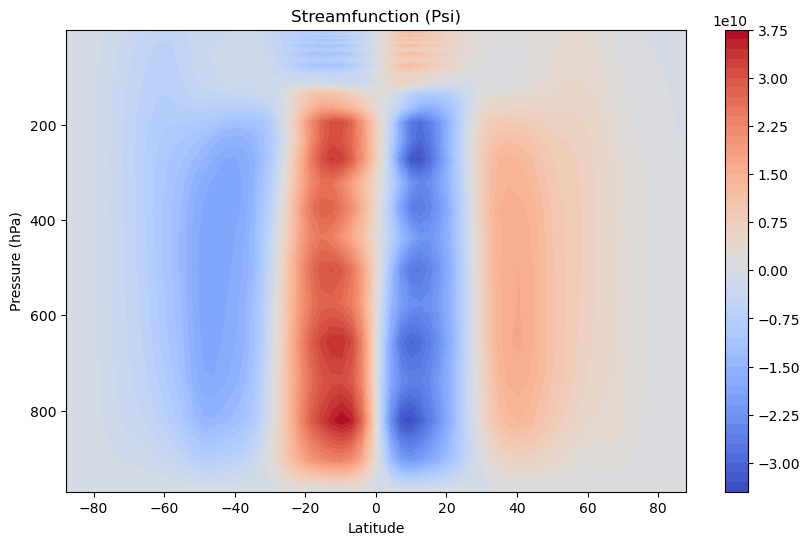

In [10]:
import xarray as xr
import numpy as np
import scipy.integrate
from tqdm import tqdm 
import matplotlib.pyplot as plt

a = 6371000  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)

# Access the 'vcomp' variable
vcomp = dataset['vcomp']

# Coordinates
press = dataset['pfull'].values  # Pressure levels
lat = dataset['lat'].values      # Latitude
lon = dataset['lon'].values      # Longitude
time = dataset['time'].values    # Time points
tau = dataset['time'][-1].values - dataset['time'][0].values

# Initialize the streamfunction array
psi = np.zeros((len(press), len(lat)))

# Calculate the streamfunction
for i in tqdm(range(len(press)), desc='Calculating Streamfunction'):
    p = press[i]
    # Integrate over the vertical, longitude, and time dimensions
    temp = scipy.integrate.simps(vcomp[:, i:, :, :], press[i:], axis=1)
    temp_u = scipy.integrate.simps(temp, lon, axis=2)
    temp_u_u = scipy.integrate.simps(temp_u, time, axis=0)
    temp_u_u_u = temp_u_u * np.cos(np.deg2rad(lat))
    psi[i, :] = temp_u_u_u

# Plotting
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(lat, press)
cp = plt.contourf(X, Y, psi* a / g / tau, levels=50, cmap='coolwarm')
plt.colorbar(cp)
plt.title('Streamfunction (Psi)')
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()  # Invert y-axis to show pressure decreasing with height
plt.show()


Calculating Streamfunction for atmos_4xdaily.nc: 100%|██████████| 40/40 [00:36<00:00,  1.11it/s]


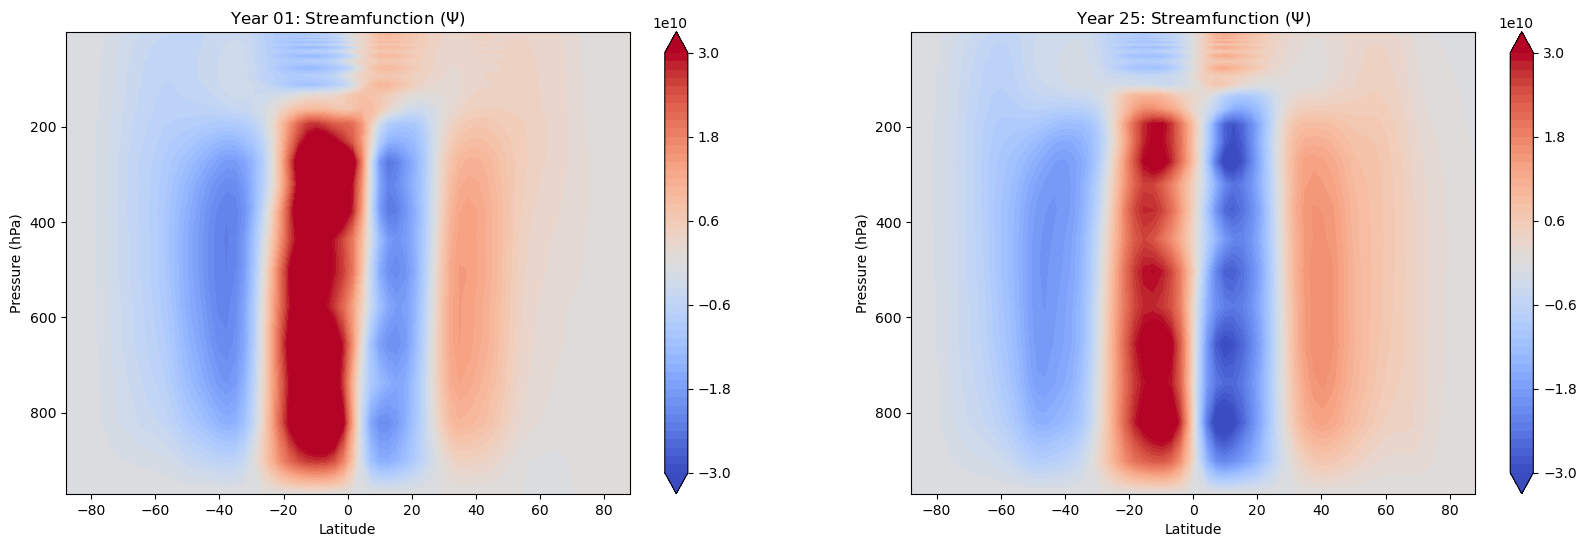

In [34]:
import xarray as xr
import numpy as np
import scipy.integrate
from tqdm import tqdm 
import matplotlib.pyplot as plt

a = 6371000  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2

# Function to calculate streamfunction
def calculate_psi(file_path):
    # Load the NetCDF file with decode_times set to False
    dataset = xr.open_dataset(file_path, decode_times=False)
    
    # Access the 'vcomp' variable
    vcomp = dataset['vcomp']
    
    # Coordinates
    press = dataset['pfull'].values  # Pressure levels
    lat = dataset['lat'].values      # Latitude
    lon = dataset['lon'].values      # Longitude
    time = dataset['time'].values    # Time points
    tau = dataset['time'][-1].values - dataset['time'][0].values
    
    # Initialize the streamfunction array
    psi = np.zeros((len(press), len(lat)))
    
    # Calculate the streamfunction
    for i in tqdm(range(len(press)), desc=f'Calculating Streamfunction for {os.path.basename(file_path)}'):
        p = press[i]
        # Integrate over the vertical, longitude, and time dimensions
        temp = scipy.integrate.simps(vcomp[:, i:, :, :], press[i:], axis=1)
        temp_u = scipy.integrate.simps(temp, lon, axis=2)
        temp_u_u = scipy.integrate.simps(temp_u, time, axis=0)
        temp_u_u_u = temp_u_u * np.cos(np.deg2rad(lat))
        psi[i, :] = temp_u_u_u * a / g / tau

    return psi, press, lat

# Paths to the NetCDF files
file_path1 = '/scratch/negishi/yan481/3004/01/atmos_4xdaily.nc'
file_path2 = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Calculate psi for each year
psi1, press1, lat1 = calculate_psi(file_path1)
psi2, press2, lat2 = calculate_psi(file_path2)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# # Define color range for consistency across plots
# vmin, vmax = -3e10, 3e10

# X1, Y1 = np.meshgrid(lat1, press1)
# cp1 = ax1.contourf(X1, Y1, psi1, levels=50, cmap='coolwarm', vmin=vmin, vmax=vmax)
# fig.colorbar(cp1, ax=ax1)
# ax1.set_title('Year 01: Streamfunction (Psi)')
# ax1.set_xlabel('Latitude')
# ax1.set_ylabel('Pressure (hPa)')
# ax1.invert_yaxis()

# X2, Y2 = np.meshgrid(lat2, press2)
# cp2 = ax2.contourf(X2, Y2, psi2, levels=50, cmap='coolwarm', vmin=vmin, vmax=vmax)
# fig.colorbar(cp2, ax=ax2)
# ax2.set_title('Year 25: Streamfunction (Psi)')
# ax2.set_xlabel('Latitude')
# ax2.set_ylabel('Pressure (hPa)')
# ax2.invert_yaxis()

# plt.show()

# Define color range and levels for consistency across plots
vmin, vmax = -3e10, 3e10
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

X1, Y1 = np.meshgrid(lat1, press1)
cp1 = ax1.contourf(X1, Y1, psi1, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp1, ax=ax1, ticks=np.linspace(vmin, vmax, 6))  # Add colorbar with ticks at regular intervals
ax1.set_title(r'Year 01: Streamfunction ($\Psi$)')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Pressure (hPa)')
ax1.invert_yaxis()

X2, Y2 = np.meshgrid(lat2, press2)
cp2 = ax2.contourf(X2, Y2, psi2, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp2, ax=ax2, ticks=np.linspace(vmin, vmax, 6))  # Ensure same colorbar for second plot
ax2.set_title(r'Year 25: Streamfunction ($\Psi$)')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Pressure (hPa)')
ax2.invert_yaxis()

plt.show()


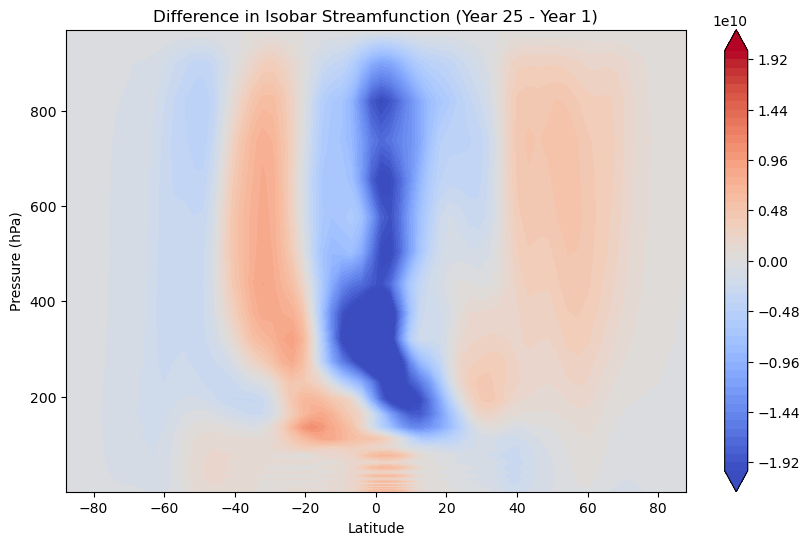

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming psi1, psi2, lat1, and theta_0_range1 are already defined from the previous computation

# Compute the difference between the two streamfunctions
psi_diff = psi2 - psi1

vmin, vmax = -2e10, 2e10
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

# Plotting the difference
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(lat1, press1)  # Use the coordinates from either year (assuming they are the same)
cp = plt.contourf(X, Y, psi_diff, levels=levels, cmap='coolwarm', extend='both')
plt.colorbar(cp)
plt.title('Difference in Isobar Streamfunction (Year 25 - Year 1)')
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')
plt.show()


$$
\begin{aligned}
& \Psi_\theta\left(\theta_0, \phi\right)=\frac{1}{\tau} \int_0^\tau \int_0^{2 \pi} \int_0^{p_{\text {suff }}} H\left(\theta_0-\theta\right) v a \cos \phi \frac{d p}{g} d \lambda d t
\end{aligned}
$$

$$
\theta=\left(\frac{p_0}{p}\right)^{\frac{R}{C_{\mathrm{p}}}} T
$$

Theta_0 calculations: 21it [01:00,  2.89s/it]
Theta_0 calculations: 21it [01:00,  2.88s/it]


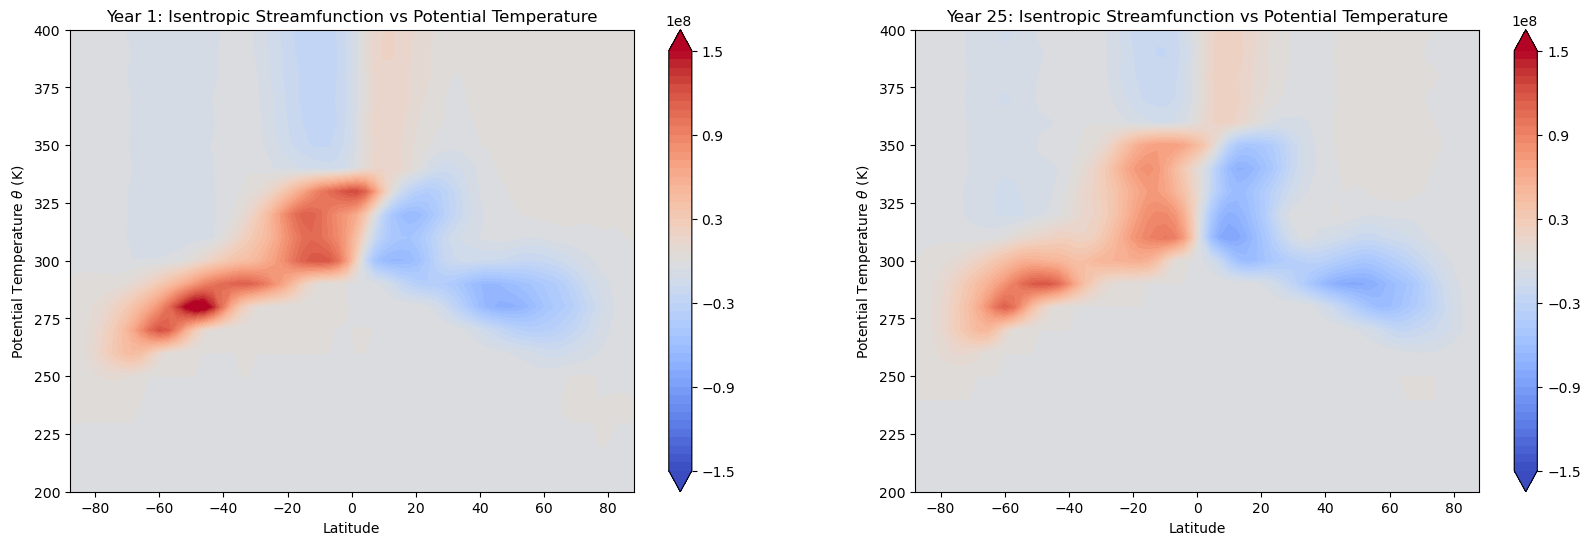

In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import os
import glob
import scipy.integrate

# Constants
a = 6.371e6  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2
R = 287.05   # Gas constant for dry air
Cp = 1004    # Specific heat at constant pressure for dry air
p0 = 1000    # Reference pressure in hPa

# Function to calculate the isentropic streamfunction
def calculate_psi(file_path):
    # Load the NetCDF file with decode_times set to False
    dataset = xr.open_dataset(file_path, decode_times=False)
    
    # Access variables
    vcomp = dataset['vcomp']
    ta = dataset['temp']
    
    # Calculate potential temperature
    theta = ta * (p0 / vcomp['pfull']) ** (R / Cp)
    
    # Coordinates
    time = dataset['time'].values    # Time points
    tau = dataset['time'][-1].values - dataset['time'][0].values
    
    # Compute streamfunction across latitude and theta_0 levels
    theta_0_range = np.linspace(200, 400, 21)
    psi = xr.DataArray(np.zeros((len(theta_0_range), len(ta.lat))),
                       dims=["theta_0", "lat"],
                       coords={"theta_0": theta_0_range, "lat": ta.lat})
    
    with ProgressBar():
        for idx, theta_0 in tqdm(enumerate(theta_0_range), desc='Theta_0 calculations'):
            # Apply Heaviside function to filter temperature fields
            H = xr.where(theta_0 >= theta, 1, 0)
            v_masked = vcomp * H
        
            # Integrate using Xarray across pressure levels, longitude, and time
            temp_theta = v_masked.integrate('pfull').integrate('lon').mean('time')
            temp_cos = temp_theta * np.cos(np.deg2rad(ta.lat))
            psi[idx, :] = temp_cos * a / g / tau
        
        # Trigger the computation
        psi = psi.compute()
    return psi, ta.lat.values, theta_0_range

# Paths to the NetCDF files
file_path1 = '/scratch/negishi/yan481/3004/01/atmos_4xdaily.nc'
file_path2 = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Calculate psi for each year
psi1, lat1, theta_0_range1 = calculate_psi(file_path1)
psi2, lat2, theta_0_range2 = calculate_psi(file_path2)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Define color range and levels for consistency across plots
vmin, vmax = -1.5e8, 1.5e8
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

X1, Y1 = np.meshgrid(lat1, theta_0_range1)
cp1 = ax1.contourf(X1, Y1, psi1, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp1, ax=ax1, ticks=np.linspace(vmin, vmax, 6))  # Add colorbar with ticks at regular intervals
ax1.set_title('Year 1: Isentropic Streamfunction vs Potential Temperature')
ax1.set_xlabel('Latitude')
ax1.set_ylabel(r'Potential Temperature $\theta$ (K)')

X2, Y2 = np.meshgrid(lat2, theta_0_range2)
cp2 = ax2.contourf(X2, Y2, psi2, levels=levels, cmap='coolwarm', extend='both')
fig.colorbar(cp2, ax=ax2, ticks=np.linspace(vmin, vmax, 6))  # Ensure same colorbar for second plot
ax2.set_title('Year 25: Isentropic Streamfunction vs Potential Temperature')
ax2.set_xlabel('Latitude')
ax2.set_ylabel(r'Potential Temperature $\theta$ (K)')

plt.show()



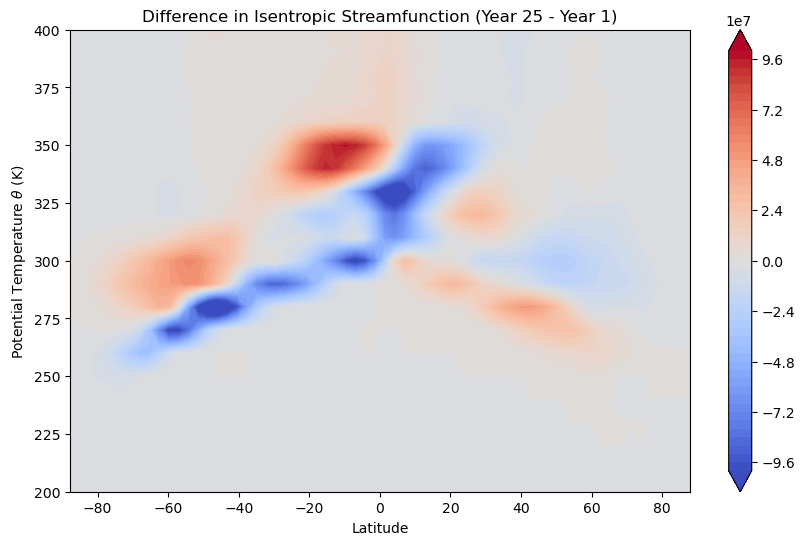

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming psi1, psi2, lat1, and theta_0_range1 are already defined from the previous computation

# Compute the difference between the two streamfunctions
psi_diff = psi2 - psi1

vmin, vmax = -1e8, 1e8
levels = np.linspace(vmin, vmax, 51)  # Create 50 intervals within the specified range

# Plotting the difference
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(lat1, theta_0_range1)  # Use the coordinates from either year (assuming they are the same)
cp = plt.contourf(X, Y, psi_diff, levels=levels, cmap='coolwarm', extend='both')
plt.colorbar(cp)
plt.title('Difference in Isentropic Streamfunction (Year 25 - Year 1)')
plt.xlabel('Latitude')
plt.ylabel(r'Potential Temperature $\theta$ (K)')
plt.show()


Theta_0 calculations: 21it [01:02,  2.97s/it]


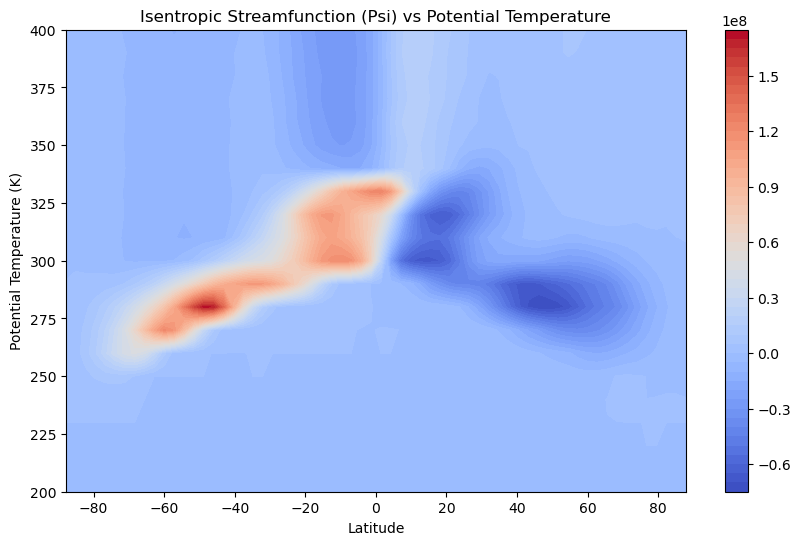

In [25]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar  # Import the ProgressBar
import os
import glob
import scipy.integrate


# Constants
a = 6.371e6  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2
R = 287.05   # Gas constant for dry air
Cp = 1004    # Specific heat at constant pressure for dry air
p0 = 1000    # Reference pressure in hPa

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/01/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)

# Access the 'vcomp' variable
vcomp = dataset['vcomp']
ta = dataset['temp']

# Calculate potential temperature
theta = ta * (p0 / vcomp['pfull']) ** (R / Cp)



# Coordinates
press = dataset['pfull'].values  # Pressure levels
lat = dataset['lat'].values      # Latitude
lon = dataset['lon'].values      # Longitude
time = dataset['time'].values    # Time points
tau = dataset['time'][-1].values - dataset['time'][0].values



# Compute streamfunction across latitude and theta_0 levels
theta_0_range = np.linspace(200, 400, 21)
psi = xr.DataArray(np.zeros((len(theta_0_range), len(ta.lat))),
                   dims=["theta_0", "lat"],
                   coords={"theta_0": theta_0_range, "lat": ta.lat})

with ProgressBar():
    for idx, theta_0 in tqdm(enumerate(theta_0_range), desc='Theta_0 calculations'):
        # Apply Heaviside function to filter temperature fields
        H = xr.where(theta_0 >= theta, 1, 0)
        v_masked = vcomp * H
    
        # Integrate using Xarray across pressure levels, longitude, and time
        temp_theta = v_masked.integrate('pfull').integrate('lon').mean('time')
        temp_cos = temp_theta * np.cos(np.deg2rad(ta.lat))
        psi[idx, :] = temp_cos * a / g / tau
    
    # Trigger the computation
    psi = psi.compute()

# Plotting for potential temperature streamfunction
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(ta.lat.values, theta_0_range)
cp = plt.contourf(X, Y, psi, levels=50, cmap='coolwarm')  # Plot as a function of theta_0
plt.colorbar(cp)
plt.title('Isentropic Streamfunction (Psi) vs Potential Temperature')
plt.xlabel('Latitude')
plt.ylabel('Potential Temperature (K)')
plt.gca()
plt.show()


Theta_0 calculations: 21it [01:02,  2.99s/it]


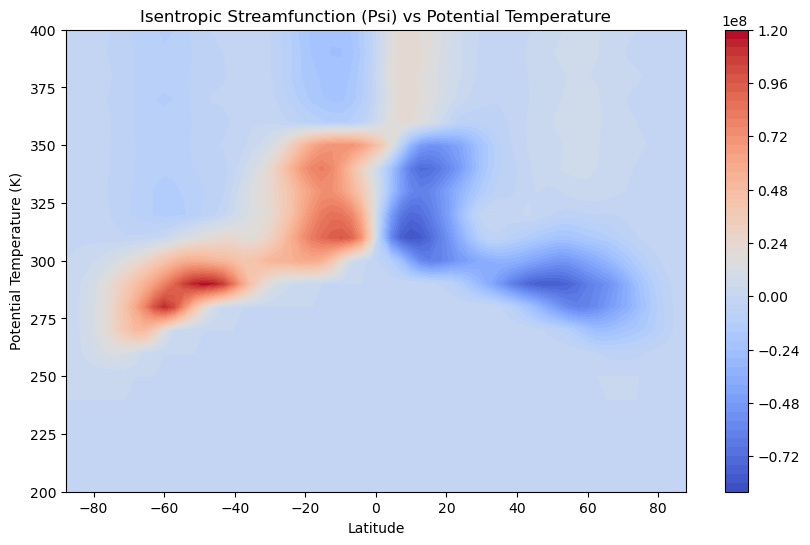

In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar  # Import the ProgressBar
import os
import glob
import scipy.integrate


# Constants
a = 6.371e6  # Earth's radius in meters
g = 9.81     # Acceleration due to gravity in m/s^2
R = 287.05   # Gas constant for dry air
Cp = 1004    # Specific heat at constant pressure for dry air
p0 = 1000    # Reference pressure in hPa

# Path to the NetCDF file
file_path = '/scratch/negishi/yan481/3004/25/atmos_4xdaily.nc'

# Load the NetCDF file with decode_times set to False
dataset = xr.open_dataset(file_path, decode_times=False)

# Access the 'vcomp' variable
vcomp = dataset['vcomp']
ta = dataset['temp']

# Calculate potential temperature
theta = ta * (p0 / vcomp['pfull']) ** (R / Cp)



# Coordinates
press = dataset['pfull'].values  # Pressure levels
lat = dataset['lat'].values      # Latitude
lon = dataset['lon'].values      # Longitude
time = dataset['time'].values    # Time points
tau = dataset['time'][-1].values - dataset['time'][0].values



# Compute streamfunction across latitude and theta_0 levels
theta_0_range = np.linspace(200, 400, 21)
psi = xr.DataArray(np.zeros((len(theta_0_range), len(ta.lat))),
                   dims=["theta_0", "lat"],
                   coords={"theta_0": theta_0_range, "lat": ta.lat})

with ProgressBar():
    for idx, theta_0 in tqdm(enumerate(theta_0_range), desc='Theta_0 calculations'):
        # Apply Heaviside function to filter temperature fields
        H = xr.where(theta_0 >= theta, 1, 0)
        v_masked = vcomp * H
    
        # Integrate using Xarray across pressure levels, longitude, and time
        temp_theta = v_masked.integrate('pfull').integrate('lon').mean('time')
        temp_cos = temp_theta * np.cos(np.deg2rad(ta.lat))
        psi[idx, :] = temp_cos * a / g / tau
    
    # Trigger the computation
    psi = psi.compute()

# Plotting for potential temperature streamfunction
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(ta.lat.values, theta_0_range)
cp = plt.contourf(X, Y, psi, levels=50, cmap='coolwarm')  # Plot as a function of theta_0
plt.colorbar(cp)
plt.title('Isentropic Streamfunction (Psi) vs Potential Temperature')
plt.xlabel('Latitude')
plt.ylabel('Potential Temperature (K)')
plt.gca()
plt.show()
